In [6]:
import pickle
import os
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
import nltk
import pymorphy2 
morph = pymorphy2.MorphAnalyzer()

from collections import Counter

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, utils

import random

# О чем этот ноутбук

Данные были собраны с анонимной борды 2ch.hk. На каждый раздел собрано несколько тысяч постов. Разделы ограничил пятью классами (железо больше не вывозит). Задача - классифицировать посты по разделам. Это реально полезно, т.к. существует общий раздел без определенной тематики. Многие юзеры недовольны тем, что туда пишут то, что нужно писать в определенном разделе.

**Предупреждение:** Крайне не рекомендуется читать посты во избежание травмирования психики!

## Settings

In [3]:
data_dir = 'data_all_posts'
TO_INITIAL_FORM = True # приводить ли слова к начальной форме (лучше приводить)
MESSAGE_LEN = 50 # все векторы сообщений приводятся к этой длине (обрезаются / дополняются пустотой)
MIN_WORDS = 5 # минимальное число слов в сообщении, при котором оно считается пригодным для использования
MAX_SAMPLES_PER_CLASS = None # сколько сообщений на один класс, None - автоматически по самому маленькому классу

## Data

Определяем те слова, которые будем выкидывать: предлоги и т.п., теги, названия разделов в самих сообщениях (так будет честнее)

In [3]:
stops = stopwords.words("russian") + stopwords.words("english")
htmls = ['blank', 'rel', 'href', 'https', 'br', 'strong', 'nofollow',
         'target', 'link', 'noreferrer', 'span', 'class', 'index',
         'html', 'post', 'reply', 'quot', 'org', 'ch', 'hk', 'noopener',
         'unkfunc', 'tags', 'size', 'width', 'block', 'td', 'pointer',
         'background', 'bold', 'text', 'margin', 'type', 'style', 'padding',
         'radius', 'hover', 'max', 'cursor', 'px', 'decoration', 'pr', 'wrap',
         'visited', 'webkit', 'font', 'important', 'border', 'fff', 'transition',
         'top', 'css', 'display', 'none', 'title', 'flex', 'bottom', 'ff', 'weight',
         'color', 'container', 'h', 'table', 'center', 'pt', 'align', 'b', 'hashlink',
         'res', 'data', 'thread', 'data', 'num', 'gt']
boards_mentioning =  ['o', 'soc', 'media', 'r', 'int', 'po',
                      'news', 'hry', 'au', 'bi', 'biz', 'bo',
                      'c', 'cc', 'em', 'fa', 'fiz', 'fl', 'ftb',
                      'hh', 'hi', 'me', 'mg', 'mlp', 'mo', 'mov',
                      'mu', 'ne', 'psy', 're', 'sci', 'sf', 'sn',
                      'sp', 'spc', 'tv', 'un', 'w', 'wh', 'wm',
                      'wp', 'zog', 'de', 'di', 'diy', 'izd',
                      'mus', 'pa', 'p', 'wrk', 'trv', 'gd',
                      'hw', 'mobi', 'pr', 'ra', 's', 't', 'web',
                      'bg', 'cg', 'gsg', 'tes', 'v', 'vg', 'wr',
                      'a', 'fd', 'ja', 'ma']

In [4]:
def read_picle_file(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

In [5]:
def read_boards(dir_name):
    boards = []
    for file in tqdm(os.listdir(dir_name)):
        filename = os.fsdecode(file)
        data = read_picle_file(os.path.join(dir_name, filename))
        boards.append(data)
    return boards

In [6]:
def select_boards(data, board_short_names):
    result = []
    for bsn in board_short_names:
        for d in data:
            if d['board_short_name'] == bsn:
                result.append(d)
    return result

In [7]:
def get_words(data):
    words = []
    for d in data:
        for m in d['messages']:
            words += (m.split(' '))
    return words

In [8]:
def get_words_str(words_list):
    return ' '.join(words_list)

**Читаем все данные**

In [9]:
data = read_boards(data_dir)

  0%|          | 0/70 [00:00<?, ?it/s]

**Выбираем нужные разделы**   
- di - столовая
- mov - фильмы
- ne - животные и природа
- sci - наука
- pr - программирование

In [10]:
data_small = select_boards(data, ['pr', 'di', 'mov', 'ne', 'sci'])
# ['o', 'soc', 'media', 'r', 'int', 'po', 'news', 'hry', 'au', 'bi', 'biz', 'bo', 'c', 'cc', 'em', 'fa', 'fiz', 'fl', 'ftb', 'hh', 'hi', 'me', 'mg',
# 'mlp', 'mo', 'mov', 'mu', 'ne', 'psy', 're', 'sci', 'sf', 'sn', 'sp', 'spc', 'tv', 'un', 'w', 'wh', 'wm', 'wp', 'zog', 'de', 'di', 'diy', 'izd', 'mus', 'pa',
# 'p', 'wrk', 'trv', 'gd', 'hw', 'mobi', 'pr', 'ra', 's', 't', 'web', 'bg', 'cg', 'gsg', 'tes', 'v', 'vg', 'wr', 'a', 'fd', 'ja', 'ma']

In [11]:
CLASS_COUNT = len(data_small)

In [12]:
CLASS_COUNT

5

In [13]:
del data # это больше не нужно, память лишней не бывает

**Делим на слова, чистим от всякого мусора, предлогов и т.п.**

In [14]:
def is_good_word(word, stops, htmls, boards_mentioning):
    if word not in stops and word not in htmls and word not in boards_mentioning:
        return True
    return False

In [15]:
def data_to_array(data):
    messages = []
    labels = []
    for d in data:
        for m in d['messages']:
            labels.append(d['board_short_name'])
            messages.append(m)
    return [messages, labels]

In [16]:
data_arr = data_to_array(data_small)

In [17]:
len(data_arr[0])

127943

In [18]:
def clean_data_arr(data_arr):
    new_messages = []
    for m in tqdm(data_arr[0]):
        new_m = []
        for w in m.split(' '):
            if is_good_word(w, stops, htmls, boards_mentioning):
                new_m.append(w)
        new_messages.append(new_m)
    return [new_messages, data_arr[1]]

In [19]:
clear_data_arr = clean_data_arr(data_arr)

  0%|          | 0/127943 [00:00<?, ?it/s]

In [20]:
len(clear_data_arr[0]), len(clear_data_arr[1])

(127943, 127943)

**Убираем слишком короткие сообщения**

In [21]:
def remove_too_short_messages(data_arr, min_words):
    new_messages = []
    new_labels = []
    for i, m in tqdm(enumerate(data_arr[0])):
        if len(m) >= min_words:
            new_messages.append(m)
            new_labels.append(data_arr[1][i])
    return [new_messages, new_labels]

In [22]:
clear_data_arr = remove_too_short_messages(clear_data_arr, MIN_WORDS)

0it [00:00, ?it/s]

In [23]:
len(clear_data_arr[0]), len(clear_data_arr[1])

(92839, 92839)

**Что по балансу?**

(array([24872.,     0., 28075.,     0.,     0., 23645.,     0.,  7579.,
            0.,  8668.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

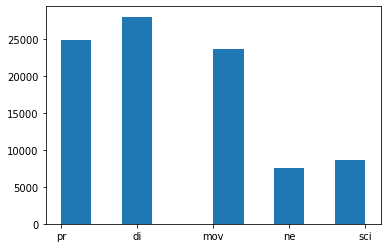

In [24]:
plt.hist(clear_data_arr[1])

Классы не сбалансированы

In [25]:
def balance_data(data_arr, max_samples_per_class=None):
    # shuffle together
    tmp = list(zip(data_arr[0], data_arr[1]))
    random.shuffle(tmp)
    data_arr[0], data_arr[1] = zip(*tmp)
    
    distr_counters = dict()
    if max_samples_per_class is None:
        for y in data_arr[1]:
            if y not in distr_counters.keys():
                distr_counters[y] = 0
            else:
                distr_counters[y] += 1
        max_samples_per_class = min(distr_counters.values())
    
    xx = []
    yy = []
    counters = dict()
    for x, y in zip(data_arr[0], data_arr[1]):
        if y not in counters.keys():
            counters[y] = 0
            xx.append(x)
            yy.append(y)
        else:
            if counters[y] <= max_samples_per_class:
                counters[y] += 1
                xx.append(x)
                yy.append(y)
    return [xx, yy]

In [26]:
clear_data_arr = balance_data(clear_data_arr, MAX_SAMPLES_PER_CLASS)

(array([7580.,    0., 7579.,    0.,    0., 7580.,    0., 7580.,    0.,
        7580.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

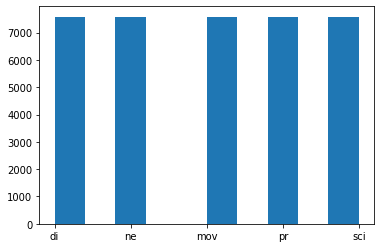

In [27]:
plt.hist(clear_data_arr[1])

Теперь сбалансированы (андерсемплинг)

**Переводим слова в начальную форму**

In [28]:
def to_initial_form(data_arr):
    for i in tqdm(range(len(data_arr[0]))):
        for j in range(len(data_arr[0][i])):
            data_arr[0][i][j] = morph.parse(data_arr[0][i][j])[0].normal_form
    return data_arr

In [29]:
if TO_INITIAL_FORM: clear_data_arr = to_initial_form(clear_data_arr)

  0%|          | 0/37899 [00:00<?, ?it/s]

**Кодируем сообщения, проверяем возможность декодировать**

Создается словарь уникальных слов {слово : число, ...}. При практическом использовании НС в него можно будет добавлять новые слова (функция в конце блокнота). Метки кодируются +- так же.

In [30]:
def encode_messages(data_arr):
    words = []
    for m in data_arr[0]:
        words += m
    words = list(set(words))
    ddict = dict()
    for i, w in enumerate(words):
        ddict[w] = i+1
    for i in range(len(data_arr[0])):
        for j in range(len(data_arr[0][i])):
            data_arr[0][i][j] = ddict[data_arr[0][i][j]]
    res_dict = {v: k for k, v in ddict.items()}
    res_dict[0] = ''
    return data_arr, res_dict

In [31]:
def encode_labels(data_arr):
    ddict = dict()
    keys = list(set(data_arr[1]))
    for i, k in enumerate(keys):
        ddict[k] = i
    for i in range(len(data_arr[1])):
        data_arr[1][i] = ddict[data_arr[1][i]]
    return data_arr, {v: k for k, v in ddict.items()}

In [32]:
def decode_message(encoded, messages_dict, npmode=True):
    if npmode:
        encoded = encoded.tolist()
    return ' '.join([messages_dict[int(v)] for v in encoded]).strip()

def decode_label(encoded, labels_dict):
    return labels_dict[encoded]

In [33]:
clear_data_arr, messages_dict = encode_messages(clear_data_arr)
clear_data_arr, labels_dict = encode_labels(clear_data_arr)

In [36]:
decode_message(clear_data_arr[0][11], messages_dict, npmode=False)

'анонас помочь сегодня вспомнить один вещь который слышать лекция утверждать правдивость хотеть найти источник помнить ещё это услышать общий человек говорить дух младенец мочь кричать болеть просто снизить вероятность секс родитель такой образ избавить конкуренция родительский внимание вид брат сестра возможно говориться обезьяна точно помнить такой слышать вне зависимость правда это подсказать мочь теория ознакомиться мб это услышать вячеслав дубынин ведущий зверь точно уверенный просто мало такой лекция слушать сапольский точно это пытаться переслушивать ролик тема находить точно это слышать вопрос надеяться ваш помощь чета зациклиться хотеть убедиться ошизеть ключевой слово никак гуглиться мочь это выдумать это шизый теория равно подсказать автор спасибо'

**Смотрим, сколько слов содержат сообщения**

In [37]:
def plot_words_count_distr(data_arr):
    counts = [len(m) for m in data_arr[0]]
    counter = Counter(counts)
    plt.bar(counter.keys(), counter.values())

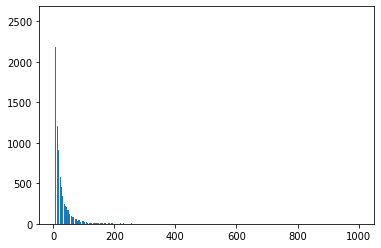

In [38]:
plot_words_count_distr(clear_data_arr)

In [39]:
maxlen = -1
minlen = 9999999999
for m in clear_data_arr[0]:
    if len(m) > maxlen:
        maxlen = len(m)
    if len(m) < minlen:
        minlen = len(m)
maxlen, minlen

(1001, 5)

**Приводим векторы сообщений к единой длине**

In [40]:
def equalize_number_of_words(data_arr, words_count):
    for i in tqdm(range(len(data_arr[0]))):
        if (len(data_arr[0][i]) < words_count):
            data_arr[0][i] = data_arr[0][i] + [0]*(words_count-len(data_arr[0][i]))
        else:
            data_arr[0][i] = data_arr[0][i][:words_count]
    return data_arr

In [41]:
clear_data_arr = equalize_number_of_words(clear_data_arr, MESSAGE_LEN) # 200

  0%|          | 0/37899 [00:00<?, ?it/s]

In [42]:
maxlen = -1
minlen = 9999999999
for m in clear_data_arr[0]:
    if len(m) > maxlen:
        maxlen = len(m)
    if len(m) < minlen:
        minlen = len(m)
maxlen, minlen

(50, 50)

**List -> np.array**

In [43]:
def conver_to_np(data_arr):
    labels = np.array(data_arr[1], dtype='float32')
    msgs = []
    for m in tqdm(data_arr[0]):
        msgs.append(np.array(m, dtype='float32'))
    return [np.array(msgs), np.array(labels)]

In [44]:
clear_data_arr = conver_to_np(clear_data_arr)

  0%|          | 0/37899 [00:00<?, ?it/s]

In [45]:
clear_data_arr[0].shape

(37899, 50)

In [46]:
clear_data_arr[1].shape

(37899,)

**Train, validation, test**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(clear_data_arr[0], clear_data_arr[1], test_size=0.3, random_state=42)

In [48]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [49]:
X_train.shape, y_train.shape

((26529, 50), (26529,))

In [50]:
X_val.shape, y_val.shape

((3411, 50), (3411,))

In [51]:
X_test.shape, y_test.shape

((7959, 50), (7959,))

## Model

Чтобы не останавливать оверфитинг вручную:

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # 5 эпох без падения лосса на валидации -> стоп
    mode='min', 
    restore_best_weights=True
)

In [4]:
emb_size = 64 # размер эмбединга

In [61]:
input = tf.keras.Input(shape=(X_train.shape[1]))
emb = layers.Embedding(input_dim=len(messages_dict.keys()), output_dim=emb_size)(input)
gru = layers.GRU(16, return_sequences=True)(emb)
conv = layers.Conv1D(4, 8, strides=2)(gru)
flat = layers.Flatten()(conv)
dense = layers.Dense(8, activation='relu')(flat)
drop = layers.Dropout(0.3)(dense)
output = layers.Dense(CLASS_COUNT, activation='softmax')(drop)

In [62]:
model = tf.keras.Model(
    inputs=[input],
    outputs=[output],
)

In [63]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 64)            5108800   
                                                                 
 gru_1 (GRU)                 (None, 50, 16)            3936      
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 4)             516       
                                                                 
 flatten_1 (Flatten)         (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 712       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

Да, она огромная из-за большого эмбединга. Но она работает.

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [65]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
830/830 [==============================] - 10s 10ms/step - loss: 1.2877 - accuracy: 0.4266 - val_loss: 0.8294 - val_accuracy: 0.7024
Epoch 2/100
830/830 [==============================] - 8s 10ms/step - loss: 0.7082 - accuracy: 0.7318 - val_loss: 0.6451 - val_accuracy: 0.7672
Epoch 3/100
830/830 [==============================] - 8s 10ms/step - loss: 0.4481 - accuracy: 0.8357 - val_loss: 0.6867 - val_accuracy: 0.7746
Epoch 4/100
830/830 [==============================] - 8s 10ms/step - loss: 0.3266 - accuracy: 0.8806 - val_loss: 0.8514 - val_accuracy: 0.7737
Epoch 5/100
830/830 [==============================] - 8s 10ms/step - loss: 0.2460 - accuracy: 0.9078 - val_loss: 0.9870 - val_accuracy: 0.7743
Epoch 6/100
830/830 [==============================] - 8s 10ms/step - loss: 0.2080 - accuracy: 0.9236 - val_loss: 1.3035 - val_accuracy: 0.7719
Epoch 7/100
830/830 [==============================] - 8s 10ms/step - loss: 0.1873 - accuracy: 0.9339 - val_loss: 1.4021 - val_accuracy

**Train & validation Loss**

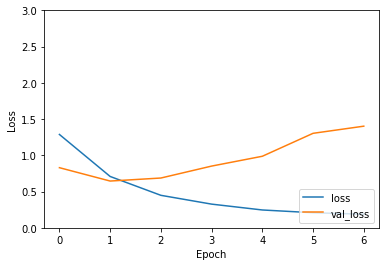

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 3])
plt.legend(loc='lower right')

Тут некрасиво, но по accuracy сойдет

**Train & validation Accuracy**

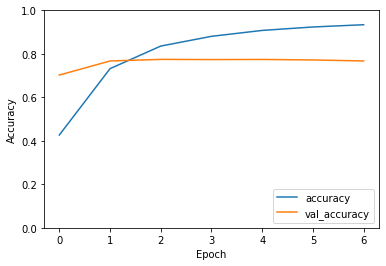

In [67]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

Нуууу, переобучение, конечно, присутствует, но...

## Test

**Метрики**

In [68]:
predict = np.argmax(model.predict(X_test), axis=1)

249/249 [==============================] - 1s 2ms/step


In [69]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78      1566
         1.0       0.79      0.69      0.74      1604
         2.0       0.86      0.75      0.80      1578
         3.0       0.83      0.73      0.78      1625
         4.0       0.72      0.84      0.77      1586

    accuracy                           0.77      7959
   macro avg       0.78      0.77      0.77      7959
weighted avg       0.78      0.77      0.77      7959



Метрики вышли очень даже неплохие. Я удивлен, что тот бред, который я напарсил, имеет какой-то смысл.

**Матрица рассогласования**

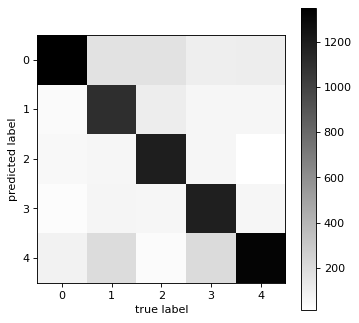

In [70]:
fig = plt.figure(figsize=(5, 5), dpi=80)
M = confusion_matrix(predict, y_test)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(CLASS_COUNT))
plt.yticks(range(CLASS_COUNT))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

Красиво

In [71]:
for i in range(CLASS_COUNT):
    print(i, decode_label(i, labels_dict))

0 di
1 mov
2 ne
3 sci
4 pr


- di - столовая
- mov - фильмы
- ne - животные и природа
- sci - наука
- pr - программирование

**Пробуем написать свое сообщение**

In [74]:
def encode_new_message(message, old_dict, words_count):
    old_dict = {v: k for k, v in old_dict.items()}
    maxvalue = max(old_dict.values())
    words = message.lower().split(' ')
    clear_words = []
    for w in words:
        if is_good_word(w, stops, htmls, boards_mentioning):
            clear_words.append(w)
    
    res_words = []
    for i, w in enumerate(clear_words):
        if w not in old_dict.keys():
            old_dict[w] = maxvalue + i + 1
        res_words.append(old_dict[w])
    if len(res_words) < words_count:
        res_words = res_words + [0] * (words_count - len(res_words))
    else:
        res_words = res_words[:words_count]
    old_dict = {v: k for k, v in old_dict.items()}
    try:
        old_dict[0] = ''
    except:
        pass
    return np.array(res_words, dtype='float32'), old_dict

In [75]:
test_new_message, messages_dict = encode_new_message(
    'Python что такое как его учить Django',
    messages_dict,
    MESSAGE_LEN)

In [76]:
test_new_message.shape, X_test.shape

((50,), (7959, 50))

In [77]:
res = np.argmax(model.predict(np.array([test_new_message])), axis=1)

1/1 [==============================] - 0s 17ms/step


In [78]:
decode_label(res[0], labels_dict)

'pr'

Работает. (pr - программирование)

## Заключение   
- Был собран датасет, содержащий сообщения из различных разделов 2ch.hk.
- Из-за ограничений по железу были выбраны пять интересующих классов.
- Данные были обработаны: удалены лишние слова, преобразованы к начальной форме, удалены слишком короткие сообщения.
- Проведена балансировка классов.
- Слова были закодированы.
- Разработана и обучена нейронная сеть для классификации сообщений по разделам.
- Несмотря на переобучение (я пытался пофиксить...) и весь бред, который пишут на борде, метрики классификации получились довольно неплохими.
- Модель можно использовать на борде для фильтрации сообщений в общем разделе (можно подружить с tf.js) или как советник раздела при написании сообщения.

Дальше лучше не читать!!!

In [72]:
def print_example(num, X_test, y_test, predict, messages_dict, labels_dict):
    print(decode_message(X_test[num], messages_dict))
    print()
    print('True label:', decode_label(y_test[num], labels_dict))
    print()
    print('Predicted label:', decode_label(predict[num], labels_dict))

In [73]:
for i in range(y_test.shape[0]):
    print_example(i, X_test, y_test, predict, messages_dict, labels_dict)
    print('-'*120)

это интересный внешке определить впадло ветеринар возить

True label: ne

Predicted label: ne
------------------------------------------------------------------------------------------------------------------------
лор высера камерон понятие вообще несовместимый два терминатор сюжет противоречить друг друг третий старый алкоголичка получать смска будущее

True label: mov

Predicted label: mov
------------------------------------------------------------------------------------------------------------------------
пельмень соус терияк молотый чёрный перец

True label: di

Predicted label: di
------------------------------------------------------------------------------------------------------------------------
голова вылить круг парка пробег зожникнуть ёбаный

True label: di

Predicted label: di
------------------------------------------------------------------------------------------------------------------------
кропнуть изображение убрать однородный фон

True label: pr

Predicted label

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:
#model.save('./saves/all-posts-mov-pr-sci-di-ne-0.77-macro')

INFO:tensorflow:Assets written to: ./saves/all-posts-mov-pr-sci-di-ne-0.77-macro\assets


INFO:tensorflow:Assets written to: ./saves/all-posts-mov-pr-sci-di-ne-0.77-macro\assets
